In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [12]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [13]:
MSFT_m = pd.read_csv("./data/LOB_2012/MSFT_2012-06-21_34200000_57600000_message_10.csv", header=None)
MSFT_ob = pd.read_csv("./data/LOB_2012/MSFT_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
MSFT_m['ticker'] = 'MSFT'
MSFT_ob['ticker'] = 'MSFT'

AMZN_m = pd.read_csv("./data/LOB_2012/AMZN_2012-06-21_34200000_57600000_message_10.csv", header=None)
AMZN_ob = pd.read_csv("./data/LOB_2012/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
AMZN_m['ticker'] = 'AMZN'
AMZN_ob['ticker'] = 'AMZN'

AAPL_m = pd.read_csv("./data/LOB_2012/AAPL_2012-06-21_34200000_57600000_message_10.csv", header=None)
AAPL_ob = pd.read_csv("./data/LOB_2012/AAPL_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
AAPL_m['ticker'] = 'AAPL'
AAPL_ob['ticker'] = 'AAPL'

INTC_m = pd.read_csv("./data/LOB_2012/INTC_2012-06-21_34200000_57600000_message_10.csv", header=None)
INTC_ob = pd.read_csv("./data/LOB_2012/INTC_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
INTC_m['ticker'] = 'INTC'
INTC_ob['ticker'] = 'INTC'

GOOG_m = pd.read_csv("./data/LOB_2012/GOOG_2012-06-21_34200000_57600000_message_10.csv", header=None)
GOOG_ob = pd.read_csv("./data/LOB_2012/GOOG_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
GOOG_m['ticker'] = 'GOOG'
GOOG_ob['ticker'] = 'GOOG'


df_m = pd.concat([MSFT_m, AMZN_m, AAPL_m, INTC_m, GOOG_m])
df_ob = pd.concat([MSFT_ob, AMZN_ob, AAPL_ob, INTC_ob, GOOG_ob])



In [14]:
M_header = ['time', 'event_type', 'order_ID',
            'size', 'price', 'direction', 'ticker']

df_m.columns = M_header


OB_header = []
for i in range(1, df_ob.shape[1]//4 + 1):
    OB_header.append(f'ask_price_{i}')
    OB_header.append(f'ask_size_{i}')
    OB_header.append(f'bid_price_{i}')
    OB_header.append(f'bid_size_{i}')

OB_header.append('ticker')

df_ob.columns = OB_header

In [15]:
df_m['time'] = pd.to_timedelta(df_m['time'], unit='s')

# Define the base date
base_date = pd.Timestamp('2012-06-21')

# Add the timedelta (time_sec) to the base date
df_m['datetime'] = base_date + df_m['time']

df_m.drop(columns=['time'], inplace=True)


In [16]:
# Creating event number
df_m['event_number'] = df_m.groupby('datetime').cumcount()
df_m['event_number_at_t'] = df_m.groupby('datetime')['event_type'].transform('count')

# Setting the composite index
df_m.set_index(['datetime', 'event_number', 'ticker'], inplace=True)

In [18]:
df_ob.index = df_m.index

In [20]:
df_ob['ask_price_1_prev'] = df_ob['ask_price_1'].shift()
df_ob['ask_size_1_prev'] = df_ob['ask_size_1'].shift()
df_ob['bid_price_1_prev'] = df_ob['bid_price_1'].shift()
df_ob['bid_size_1_prev'] = df_ob['bid_size_1'].shift()

In [22]:
# Define the start and end times
start_time = pd.to_datetime("09:15:00").time()
end_time = pd.to_datetime("15:45:00").time()

# Extract the 'datetime' level from the MultiIndex and filter based on the time
filtered_index = df_m.index.get_level_values('datetime').to_series().between_time(start_time, end_time).index

# Use the filtered index to get the filtered DataFrame
df_m_mh = df_m.loc[filtered_index]
df_ob_mh = df_ob.loc[filtered_index]

In [23]:
df_m_mh = df_m_mh[~df_m_mh.index.duplicated(keep='first')]
df_ob_mh = df_ob_mh[~df_ob_mh.index.duplicated(keep='first')]

Create features for ML prediction of direction

In [24]:
df_m_mh['midprice'] = (df_ob_mh['ask_price_1'] + df_ob_mh['bid_price_1']) / 2

In [25]:
df_m_mh['order_imb'] = (df_ob_mh['bid_size_1'] - df_ob_mh['ask_size_1']) / (df_ob_mh['bid_size_1'] + df_ob_mh['ask_size_1'])

We try to run ML models to predict the direction of hidden liquidity execution - these features mainly only make sense for event type 5

In [27]:
df_m_mh['prev_dir_t1'] = np.where(df_m_mh['event_type']==1, df_m_mh['direction'], np.nan)
df_m_mh['prev_dir_t1'] = df_m_mh['prev_dir_t1'].shift(1).ffill()
df_m_mh['prev_dir_t1'].fillna(0, inplace=True)

In [28]:
df_m_mh['next_dir_t1'] = np.where(df_m_mh['event_type']==1, df_m_mh['direction'], np.nan)
df_m_mh['next_dir_t1'] = df_m_mh['next_dir_t1'].shift(-1).bfill()
df_m_mh['next_dir_t1'].fillna(0, inplace=True)

In [29]:
df_m_mh['prev_dir_t4'] = np.where(df_m_mh['event_type']==4, df_m_mh['direction'], np.nan)
df_m_mh['prev_dir_t4'] = df_m_mh['prev_dir_t4'].shift(1).ffill()
df_m_mh['prev_dir_t4'].fillna(0, inplace=True)

In [32]:
df_m_mh['next_dir_t4'] = np.where(df_m_mh['event_type']==4, df_m_mh['direction'], np.nan)
df_m_mh['next_dir_t4'] = df_m_mh['next_dir_t4'].shift(-1).bfill()
df_m_mh['next_dir_t4'].fillna(0, inplace=True)

In [34]:
df_m_mh['agg_ratio'] = (df_m_mh['price'] - df_ob_mh['bid_price_1']) / (df_ob_mh['ask_price_1'] - df_ob_mh['bid_price_1'])

In [35]:
df_m_mh['hid_at_best'] = (df_m_mh['price'] == df_ob_mh['bid_price_1']).astype(int) - (df_m_mh['price'] == df_ob_mh['ask_price_1']).astype(int)

In [37]:
features_hid = df_m_mh[df_m_mh['event_type']==5]

In [39]:
features_hid.drop(columns=['event_type', 'order_ID', 'price', 'direction', 'midprice'], inplace=True)

In [40]:
output_hid = df_m_mh[df_m_mh['event_type']==5]['direction']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(features_hid, output_hid, test_size=0.25, random_state=42)

Random Forest Classifier

In [49]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [50]:
sum(y_pred == list(y_test))/len(y_pred)

np.float64(0.8581573896353167)

In [51]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [52]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Extract the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total tim

In [53]:
# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.86      0.86      2542
           1       0.87      0.87      0.87      2668

    accuracy                           0.87      5210
   macro avg       0.87      0.87      0.87      5210
weighted avg       0.87      0.87      0.87      5210



(array([10298.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10539.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

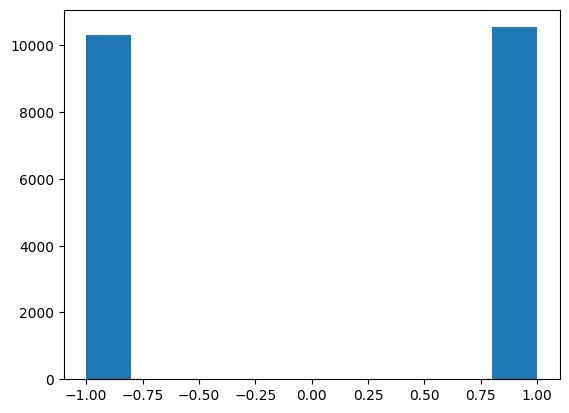

In [55]:
plt.hist(output_hid)

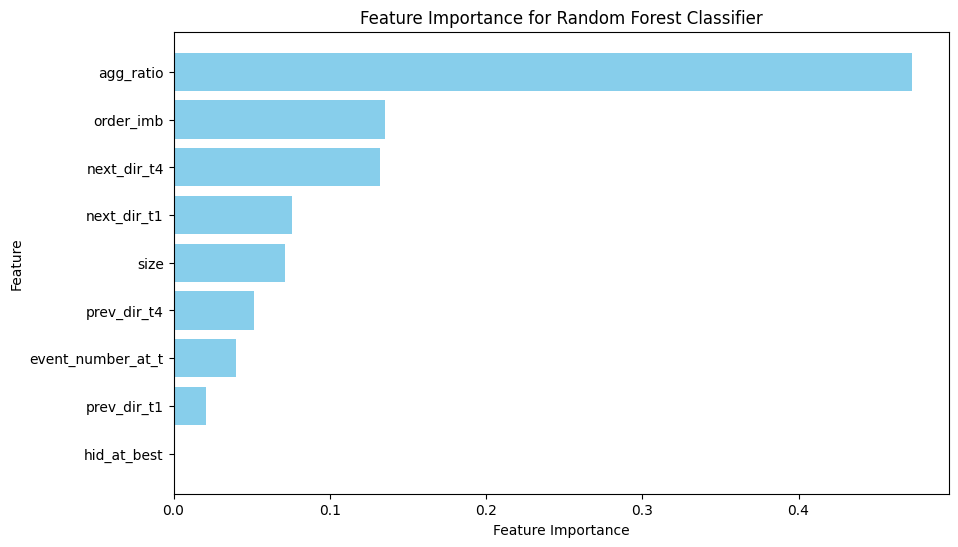

In [67]:
# Extract feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Classifier')
plt.gca().invert_yaxis()
plt.show()

Logistic Regression

In [65]:
importance_df

,Feature,Importance
7,agg_ratio,0.472361
2,order_imb,0.135416
6,next_dir_t4,0.132206
4,next_dir_t1,0.075797
0,size,0.071400
5,prev_dir_t4,0.051489
1,event_number_at_t,0.039663
3,prev_dir_t1,0.020832
8,hid_at_best,0.000836
